AR signature in python
converted from Artem Sokolov and Vlado Uzunangelov's R code

In [30]:
# %load startup_script.py

# numerical & stats 
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import itertools

# plotting
from matplotlib import pyplot as plt
import matplotlib
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.charts.attributes import ColorAttr, CatAttr
from bokeh.sampledata.autompg import autompg as df
from bokeh.models import Label
import bokeh

# machine learning
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

# import helper function in this repo
import helper

# jupyte notebook amenities
output_notebook()
%matplotlib inline
%autosave 10

# supress pandas copy-by-ref warning
pd.options.mode.chained_assignment = None

Loading BokehJS ...

Autosaving every 10 seconds


## 1. Data Preprocessing

In [24]:
def data_prep(X_df, Y_df, WCDT_df, febbo_df):
    # take "ligand" column as Y label and set "on" to 1 and "no ligand" to 0
    Y_df = Y_df[["GSM_ID", "ligand"]]
    Y_df['ligand'] = Y_df['ligand'].replace(['on'], 1)
    Y_df['ligand'] = Y_df['ligand'].replace(['no ligand'], 0)
    
    # Drop sample GSM288299, GSM288300, GSM288301 (QA by Robert and Jack)
    Y_df = Y_df[~Y_df.GSM_ID.isin(["GSM288299", "GSM288300", "GSM288301"])]
    
    # remove non-overlapping samples in X and Y
    common_samples = sorted(list(set(Y_df.GSM_ID).intersection(set(X_df.columns[1:]))))
    X_df = X_df[["Gene Symbol"] + common_samples]
    Y_df = Y_df[Y_df.GSM_ID.isin(common_samples)]
    
    # remove genes with NA
    X_df = X_df.dropna()
    
    # get overlap of genes between X_df and WCDT file
    common_genes = set(WCDT_df["gene_id"]).intersection(set(X_df["Gene Symbol"]))
    X_df = X_df[X_df["Gene Symbol"].isin(common_genes)]
    
    # rank transformation + normalization (with quantile function of exponential distribution) 
    X_df.set_index("Gene Symbol", inplace=True)
    X_orig_df = X_df.copy()
    X_df = (X_df.rank()-1)/len(X_df)
    X_df = X_df.applymap(lambda x: -np.log(1-x))

    # transpose X
    X_df = X_df.transpose()
    X_orig_df = X_orig_df.transpose()
    
    # set GSM_id as Y index
    Y_df.set_index("GSM_ID", inplace=True)    
    
    # order X and Y so that same sample name match up
    X_df.sort_index(inplace=True)
    Y_df.sort_index(inplace=True)
    assert(list(X_df.index) == list(Y_df.index))
    
    # prep WCDT data
    WCDT_df = pd.read_csv(X_WCDT_file, delimiter="\t")
    common_genes = set(WCDT_df["gene_id"]).intersection(set(X_df.columns))
    WCDT_df = WCDT_df[WCDT_df["gene_id"].isin(common_genes)]
    WCDT_df.set_index("gene_id", inplace=True)
    
    # same normalization
    WCDT_df = (WCDT_df.rank()-1)/len(WCDT_df)
    WCDT_df = WCDT_df.applymap(lambda x: -np.log(1-x))
    WCDT_df.sort_index(inplace=True)
    WCDT_df = WCDT_df.transpose()

    # mean duplicate gene scores in febbo
    febbo_df = febbo_df.rename(columns={"BinReg Coef": "Mendiratta signature"})
    febbo_df = febbo_df.groupby("Gene Symbol").median()
    
    return X_orig_df, X_df, Y_df, WCDT_df, febbo_df

In [25]:
X_cell_line_file = "data/AR/AR_cell_line_mRNA.txt"
y_file = "data/AR/AR_cell_line_clinical.txt"
X_WCDT_file = "data/WCDT_mRNA.tsv"
febbo_file = "data/AR/febbo-coeff.csv"

X_cell_line_df = pd.read_csv(X_cell_line_file, delimiter="\t")
y_df = pd.read_csv(y_file, delimiter="\t")
X_WCDT_df = pd.read_csv(X_WCDT_file, delimiter="\t")
febbo_df = pd.read_csv(febbo_file)

_, X, Y, WCDT_df, febbo_df = data_prep(X_cell_line_df, y_df, X_WCDT_df, febbo_df)

## 2. Train logistic regression and get signature

In [26]:
classifier = linear_model.LogisticRegression()
classifier.fit(X, Y['ligand'])
UC_df = pd.DataFrame(data=classifier.coef_[0], index=X.columns, columns=["UC signature"])

### 2.1 compare LR python signature with artem R signature

In [35]:
def get_sigatures(plot=False):
    df = pickle.load(open("./data/AR/AR_signatures.pkl", "rb"))
    if plot:
        for (col1, col2) in itertools.combinations(list(df.columns), 2):
            plt.figure()
            plt.scatter(df[col1], df[col2])
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.title("pearson corr %.2f" %stats.pearsonr(df[col1], df[col2])[0])
    return AR_sig

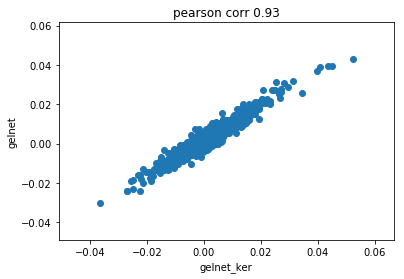

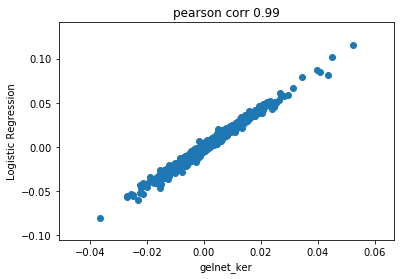

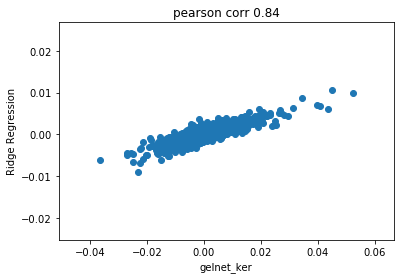

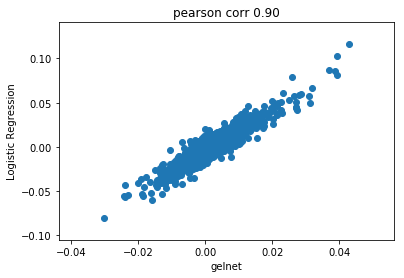

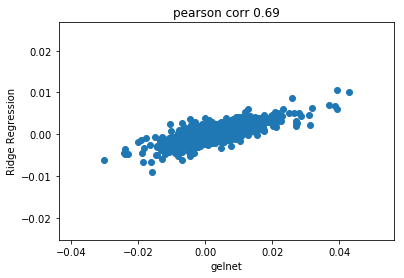

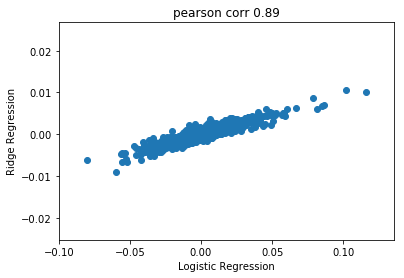

In [36]:
sig_compare = get_sigatures(plot=True)

In [23]:
list(artem_sig["gelnet"]) == list(AR_sig["gelnet"])

True

In [ ]:
molly_sig = 

### 2.2 compare LR python signature with febbo (Mendiratta) signature

In [31]:
sig_score = pd.DataFrame(index=WCDT_df.index)

for sig in [UC_df, febbo_df]:
    common_genes = sorted(list(set(WCDT_df.columns).intersection(sig.index)))
    samples = WCDT_df[common_genes]
    signatures = sig.loc[common_genes]
    sig_score[sig.columns[0]] = np.matmul(samples.as_matrix(), signatures.as_matrix())


# correlation of sample scores
p = bokeh.plotting.figure(title="spearman rank correlation %.3f" %stats.spearmanr(
    sig_score["UC signature"], sig_score["Mendiratta signature"])[0])
p.scatter(sig_score["UC signature"], sig_score["Mendiratta signature"])
p.xaxis.axis_label = "UCSC-UCSF signature score"
p.yaxis.axis_label = "Mendiratta signature score"
for index, row in sig_score.iterrows():
    text = Label(x=row["UC signature"], y=row["Mendiratta signature"], 
                 text=str(index), text_font_size="7pt")
    p.add_layout(text)

show(p)

## 3. Leave-pair-out Cross Validation 

In [35]:
classifiers = {#"Enet": linear_model.ElasticNet(alpha=0.1, l1_ratio=0.001),
               "Logistic Regression": linear_model.LogisticRegression(), 
               #"Lasso": linear_model.Lasso(alpha=0.01), 
               #"Ridge Regression": linear_model.Ridge(),
               #"KernelRidge": kernel_ridge.KernelRidge()
              }
print(helper.leave_pair_out_cv(X, Y, classifiers["Logistic Regression"]))

..................................................................................................................................................................................................................................................................................................................................................................................................................................1.0


## 4. Apply AR signature to WCDT samples

### 4.1 Compare AR score before and after Enza treatment

              Pre      Post  Post-Pre
Sample                               
DTB-080  0.152039  -7.66491  -7.81695
DTB-063  0.500091  -4.43158  -4.93167
DTB-176  0.684195  -3.45997  -4.14416
DTB-194 -0.126417  -3.55357  -3.42715
DTB-141  0.375937  -2.56973  -2.94567
DTB-149    1.8818  -0.63547  -2.51727
DTB-127   1.14444  -1.13832  -2.28276
DTB-137  0.821366  -1.38786  -2.20923
DTB-135  0.480915   -1.5734  -2.05431
DTB-060   4.69503   3.56131  -1.13372
DTB-024 -0.420169  -1.06728  -0.64711
DTB-022 -0.791519 -0.465876  0.325643
DTB-102  0.366787   0.71027  0.343484
DTB-073  -1.16706   1.45319   2.62025
DTB-089   -3.2217   1.31301   4.53471
DTB-111  -2.32889   2.23741    4.5663


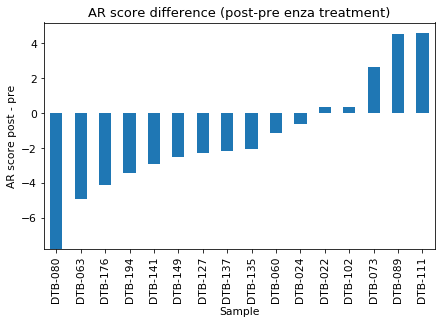

In [48]:
def extract_sample_name(name):
    if name.endswith("Pro"):
        return name[:-3]
    elif name.endswith("Pro2"):
        return name[:-4]
    else:
        assert(name[-1] in "0123456789")
        return name

assert(list(UC_df.index) == list(WCDT_df.columns))
WCDT_AR_scores = np.matmul(WCDT_df, UC_df["UC signature"])
WCDT_score_df = pd.DataFrame(WCDT_AR_scores, index=WCDT_df.index, columns=["score"])
sample_pair = pd.read_csv("data/WCDT_paired_samples.tab", delimiter="\t", index_col="Sample")
WCDT_score_df = WCDT_score_df[WCDT_score_df.index.isin(sample_pair.index)]
assert(sorted(list(sample_pair.index))==sorted(list(WCDT_score_df.index)))
sample_pair_dict = dict(zip(sample_pair.index, sample_pair['TimePoint']))
WCDT_plot_df = pd.DataFrame(columns=["Pre", "Post"])
for index, row in WCDT_score_df.iterrows():
    sample_name = extract_sample_name(index)
    sample_type = sample_pair_dict[index]
    WCDT_plot_df.set_value(sample_name, sample_type, row.score)

WCDT_plot_df["Post-Pre"] = WCDT_plot_df["Post"] - WCDT_plot_df["Pre"]
WCDT_plot_df.sort_values(by="Post-Pre", inplace=True)
WCDT_plot_df.index.rename("Sample", inplace=True)
print(WCDT_plot_df)

matplotlib.rcParams["font.size"] = 10.8
figure, ax = plt.subplots()
WCDT_plot_df.plot.bar(y="Post-Pre", figsize=(7,5), ax=ax, legend=None)
ax.set_ylabel("AR score post - pre")
ax.set_title("AR score difference (post-pre enza treatment)")
plt.gcf().subplots_adjust(bottom=0.25)
figure.savefig("./results/plots/AR_plot.png", dpi=300, figsize=(8,5))
WCDT_plot_df.to_csv("./results/WCDT_AR_scores.csv")

### 4.2 Compare AR scores of WCDT samples using two signatures

In [44]:
sig_score = sig_score[sig_score.index.isin(sample_pair.index)]
assert(sorted(list(sample_pair.index))==sorted(list(sig_score.index)))
sample_pair_dict = dict(zip(sample_pair.index, sample_pair['TimePoint']))

WCDT_plot_df = pd.DataFrame()
for sig_type in ["UC signature", "Mendiratta signature"]:
    for index, row in sig_score.iterrows():
        sample_name = extract_sample_name(index)
        sample_type = sample_pair_dict[index]
        WCDT_plot_df.set_value(sample_name, sample_type + sig_type, row[sig_type])
    WCDT_plot_df["Post-Pre "+sig_type] = (WCDT_plot_df["Post"+sig_type] - 
                                          WCDT_plot_df["Pre"+sig_type])

In [46]:
X = list(WCDT_plot_df["Post-Pre UC signature"])
Y = list(WCDT_plot_df["Post-Pre Mendiratta signature"])

spearman_rho, p_value = stats.spearmanr(X, Y)
print(spearman_rho, p_value)

p = bokeh.plotting.figure(plot_width=600, plot_height=600,
           tools=["zoom_out", "save", "reset", "resize", "box_zoom"],
    title="correlation of signature score differences, spearman rho={0:.3f}, p value = {1:.4f}".format(spearman_rho, p_value))
p.scatter(X, Y)
p.xaxis.axis_label = "WCDT signature score difference"
p.yaxis.axis_label = "Mendiratta signature score difference"
for index, row in WCDT_plot_df.iterrows():
    text = Label(x=row["Post-Pre UC signature"], 
                 y=row["Post-Pre Mendiratta signature"], 
                 text=str(index), text_font_size="9pt")
    p.add_layout(text)
show(p)
export_png(p, "./results/plots/fig2B.png")

0.741176470588 0.00101846954957


'/Users/Molly/Desktop/Stuart/CRPC_signatures/results/plots/fig2B.png'

### 4.3 Box plot of AR signature scores pre and post enza treatment

In [1]:
score_df = pd.read_csv("./results/WCDT_AR_scores.csv", index_col="Sample")

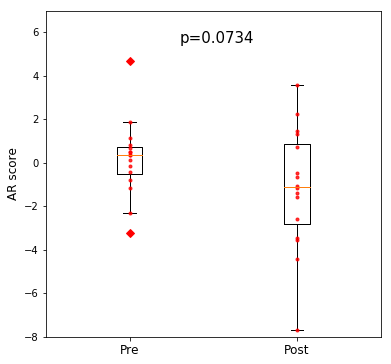

In [40]:
# boxplot 
pre_scores = list(score_df["Pre"])
post_scores = list(score_df["Post"])

fig, ax1 = plt.subplots(figsize=(6, 6))
plt.boxplot([pre_scores, post_scores], 0, 'rD')
plt.ylabel("AR score", fontsize=12)
plt.ylim([-8, 7])
xtickNames = plt.setp(ax1, xticklabels=["Pre", "Post"])
plt.setp(xtickNames, rotation=0, fontsize=12)

# plot data points
x_pre = np.random.normal(1, 0.00, size=len(pre_scores))
plt.plot(x_pre, pre_scores, 'r.', alpha=0.8)
x_post = np.random.normal(2, 0.00, size=len(pre_scores))
plt.plot(x_post, post_scores, 'r.', alpha=0.8)

p_value = stats.mannwhitneyu(pre_scores, post_scores)[1]
plt.text(1.3, 5.5, "p={0:.4f}".format(p_value), size=15)

plt.show()
fig.savefig("./results/plots/AR_box.png", dpi=300)

### 5. save AR signature score on ALL WCDT data (2-26-2018)

#### 5.1 save UC signature and Mendiratta signature in one place

In [165]:
febbo_df = pd.read_csv("./data/AR/febbo-coeff.csv")
febbo_df = febbo_df.rename(columns={"BinReg Coef": "Mendiratta signature"})
febbo_df = febbo_df.groupby("Gene Symbol").median()
AR_sig = pickle.load(open("./data/AR/AR_signatures.pkl", "rb"))
all_sigs = AR_sig.join(febbo_df).fillna(0)
assert(sorted(list(all_sigs[all_sigs["Mendiratta signature"]!=0.0].index))
       == sorted(list(set(febbo_df.index).intersection(set(AR_sig.index)))))
all_sigs.rename(columns={"Logistic Regression": "UC signature"}, inplace=True)
all_sigs[["UC signature", "Mendiratta signature"]].to_csv("./results/AR_signatures.csv")

#### 5.2 Apply AR signatures on all WCDT data

In [181]:
WCDT_df = pd.read_csv("./data/WCDT_mRNA.tsv", 
                      delimiter="\t", index_col="gene_id").T
sig_df = pd.read_csv("./results/AR_signatures.csv", index_col="gene")
WCDT_df = WCDT_df[sig_df.index]
assert(WCDT_df.shape[1] == sig_df.shape[0])
assert(list(WCDT_df.columns)==list(sig_df.index))
sig_scores = WCDT_df.dot(sig_df)

In [188]:
sig_scores.to_csv("./results/WCDT_all_samples_AR_signatures_scores.csv")

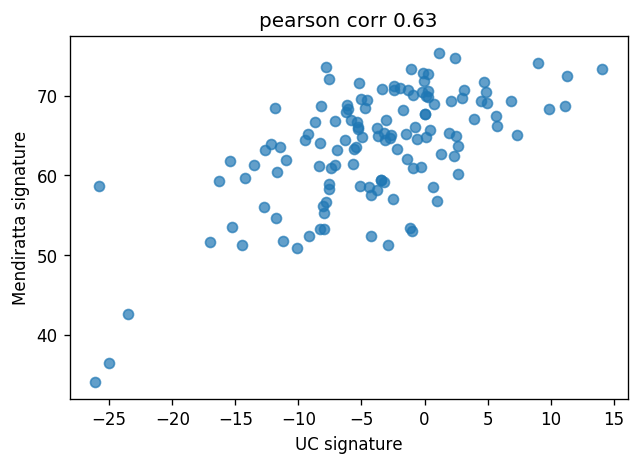

In [186]:
plt.figure(dpi=120)
plt.scatter(sig_scores["UC signature"], sig_scores["Mendiratta signature"], alpha=0.7)
plt.xlabel("UC signature")
plt.ylabel("Mendiratta signature")
plt.title("pearson corr %.2f" %stats.pearsonr(
    sig_scores["UC signature"], sig_scores["Mendiratta signature"])[0])